In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer 
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
from scipy.sparse import hstack,csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
sns.set()

In [2]:
df=pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

<p>The dataset is highly imbalanced</p>

In [6]:
df["title"].nunique()

11231

In [7]:
split_location=df["location"].apply(lambda x:str(x).strip().split(','))
split_location=split_location.apply(pd.Series)

<p>Split location in country, state and city columns</p>

In [8]:
split_location

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,US,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NZ,,Auckland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,IA,Wever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,DC,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,FL,Fort Worth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,CA,ON,Toronto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17876,US,PA,Philadelphia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,US,TX,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17878,NG,LA,Lagos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
split_location[~(split_location[4].isnull())]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
733,US,AL,Birmingham,Montgomery,Atlanta Ga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1725,US,TX,Austin,San Antonio,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4396,US,MI,Hartford,Paw Paw,Lawton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480,US,CA,San Jose,SFO,Austin,OH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4527,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4650,US,FL,Central Fl,Nort Fl,Georgia,Alabama,Tennessee,South Carolina,North Carolina,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11987,US,CA,Los Angeles,Anaheim,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12383,NL,ZH,Rotterdam,The Hague,Utrecht,Amsterdam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12467,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13181,US,CA,Los Angeles,California,San Francisco,California,San Jose,California,Manhattan,New York,Las Vegas,Nevada,Phoenix,Arizona,San Diego,California


Some jobs offers are available in multiple locations

In [10]:
df['country']=split_location[0]

In [11]:
df['location_count']=df["location"].apply(lambda x:str(x).split(', '))

In [12]:
df['location_count']=df['location_count'].apply(lambda x:max(len(x)-2,0))

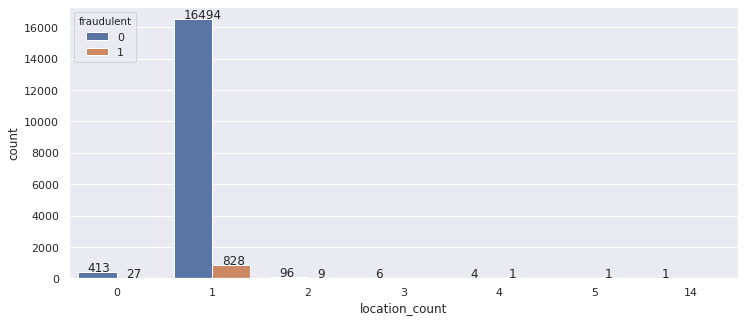

In [13]:
plt.figure(figsize=(12,5))
ax=sns.countplot(x='location_count',data=df,hue='fraudulent')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [14]:
df[((df['telecommuting']==1)&(df['location']!='none'))]['job_id'].count()

767

In [15]:
df[((df['telecommuting']==0)&(df['location'].isnull()))]['job_id'].count()

325

<p>Missing location does not mean work from home</p>

In [16]:
df['null_count']=df.isnull().sum(axis=1)

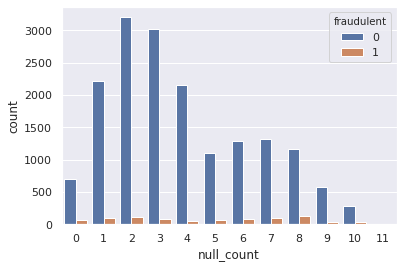

In [17]:
sns.countplot(x='null_count',data=df,hue='fraudulent');

In [18]:
# Map alpha 2 to corresponding alpha 3 country code
country_code_mapping = {"BD": "BGD", "BE": "BEL", "BF": "BFA", "BG": "BGR", "BA": "BIH", "BB": "BRB", "WF": "WLF", "BL": "BLM", "BM": "BMU", "BN": "BRN", "BO": "BOL", "BH": "BHR", "BI": "BDI", "BJ": "BEN", "BT": "BTN", "JM": "JAM", "BV": "BVT", "BW": "BWA", "WS": "WSM", "BQ": "BES", "BR": "BRA", "BS": "BHS", "JE": "JEY", "BY": "BLR", "BZ": "BLZ", "RU": "RUS", "RW": "RWA", "RS": "SRB", "TL": "TLS", "RE": "REU", "TM": "TKM", "TJ": "TJK", "RO": "ROU", "TK": "TKL", "GW": "GNB", "GU": "GUM", "GT": "GTM", "GS": "SGS", "GR": "GRC", "GQ": "GNQ", "GP": "GLP", "JP": "JPN", "GY": "GUY", "GG": "GGY", "GF": "GUF", "GE": "GEO", "GD": "GRD", "GB": "GBR", "GA": "GAB", "SV": "SLV", "GN": "GIN", "GM": "GMB", "GL": "GRL", "GI": "GIB", "GH": "GHA", "OM": "OMN", "TN": "TUN", "JO": "JOR", "HR": "HRV", "HT": "HTI", "HU": "HUN", "HK": "HKG", "HN": "HND", "HM": "HMD", "VE": "VEN", "PR": "PRI", "PS": "PSE", "PW": "PLW", "PT": "PRT", "SJ": "SJM", "PY": "PRY", "IQ": "IRQ", "PA": "PAN", "PF": "PYF", "PG": "PNG", "PE": "PER", "PK": "PAK", "PH": "PHL", "PN": "PCN", "PL": "POL", "PM": "SPM", "ZM": "ZMB", "EH": "ESH", "EE": "EST", "EG": "EGY", "ZA": "ZAF", "EC": "ECU", "IT": "ITA", "VN": "VNM", "SB": "SLB", "ET": "ETH", "SO": "SOM", "ZW": "ZWE", "SA": "SAU", "ES": "ESP", "ER": "ERI", "ME": "MNE", "MD": "MDA", "MG": "MDG", "MF": "MAF", "MA": "MAR", "MC": "MCO", "UZ": "UZB", "MM": "MMR", "ML": "MLI", "MO": "MAC", "MN": "MNG", "MH": "MHL", "MK": "MKD", "MU": "MUS", "MT": "MLT", "MW": "MWI", "MV": "MDV", "MQ": "MTQ", "MP": "MNP", "MS": "MSR", "MR": "MRT", "IM": "IMN", "UG": "UGA", "TZ": "TZA", "MY": "MYS", "MX": "MEX", "IL": "ISR", "FR": "FRA", "IO": "IOT", "SH": "SHN", "FI": "FIN", "FJ": "FJI", "FK": "FLK", "FM": "FSM", "FO": "FRO", "NI": "NIC", "NL": "NLD", "NO": "NOR", "NA": "NAM", "VU": "VUT", "NC": "NCL", "NE": "NER", "NF": "NFK", "NG": "NGA", "NZ": "NZL", "NP": "NPL", "NR": "NRU", "NU": "NIU", "CK": "COK", "XK": "XKX", "CI": "CIV", "CH": "CHE", "CO": "COL", "CN": "CHN", "CM": "CMR", "CL": "CHL", "CC": "CCK", "CA": "CAN", "CG": "COG", "CF": "CAF", "CD": "COD", "CZ": "CZE", "CY": "CYP", "CX": "CXR", "CR": "CRI", "CW": "CUW", "CV": "CPV", "CU": "CUB", "SZ": "SWZ", "SY": "SYR", "SX": "SXM", "KG": "KGZ", "KE": "KEN", "SS": "SSD", "SR": "SUR", "KI": "KIR", "KH": "KHM", "KN": "KNA", "KM": "COM", "ST": "STP", "SK": "SVK", "KR": "KOR", "SI": "SVN", "KP": "PRK", "KW": "KWT", "SN": "SEN", "SM": "SMR", "SL": "SLE", "SC": "SYC", "KZ": "KAZ", "KY": "CYM", "SG": "SGP", "SE": "SWE", "SD": "SDN", "DO": "DOM", "DM": "DMA", "DJ": "DJI", "DK": "DNK", "VG": "VGB", "DE": "DEU", "YE": "YEM", "DZ": "DZA", "US": "USA", "UY": "URY", "YT": "MYT", "UM": "UMI", "LB": "LBN", "LC": "LCA", "LA": "LAO", "TV": "TUV", "TW": "TWN", "TT": "TTO", "TR": "TUR", "LK": "LKA", "LI": "LIE", "LV": "LVA", "TO": "TON", "LT": "LTU", "LU": "LUX", "LR": "LBR", "LS": "LSO", "TH": "THA", "TF": "ATF", "TG": "TGO", "TD": "TCD", "TC": "TCA", "LY": "LBY", "VA": "VAT", "VC": "VCT", "AE": "ARE", "AD": "AND", "AG": "ATG", "AF": "AFG", "AI": "AIA", "VI": "VIR", "IS": "ISL", "IR": "IRN", "AM": "ARM", "AL": "ALB", "AO": "AGO", "AQ": "ATA", "AS": "ASM", "AR": "ARG", "AU": "AUS", "AT": "AUT", "AW": "ABW", "IN": "IND", "AX": "ALA", "AZ": "AZE", "IE": "IRL", "ID": "IDN", "UA": "UKR", "QA": "QAT", "MZ": "MOZ"}

In [19]:
df['country']=df['country'].apply(lambda x:country_code_mapping[x] if x!='nan' else 'nan')

In [20]:
fig = go.Figure(data=go.Choropleth(
    locations = df['country'].value_counts().index,
    z = df['country'].value_counts().values,
    text = df['country'].value_counts().index,
    colorscale = 'Blues',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'job ads',
))

fig.update_layout(
    title_text='Total job ads',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),

)

fig.show()

In [21]:
fraud_list=df[df['fraudulent']==1]['country'].value_counts().to_dict()
total_count_list=df['country'].value_counts().to_dict()
percent_fraud_dict={}
for country in total_count_list.keys():
    if country in fraud_list:
        percent_fraud_dict[country]=fraud_list[country]/total_count_list[country]*100
    else:
        percent_fraud_dict[country]=0
percent_fraud_dict=OrderedDict(sorted(percent_fraud_dict.items())) 

In [22]:
fig = go.Figure(data=go.Choropleth(
    locations = list(percent_fraud_dict.keys()),
    z = list(percent_fraud_dict.values()),
    text =  list(percent_fraud_dict.keys()),
    colorscale = 'Reds',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Job ads percent',
))

fig.update_layout(
    title_text='Percentage of fraudulent job ads',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),

)

fig.show()

In [23]:
df['department'].value_counts().head(20)

Sales                     551
Engineering               487
Marketing                 401
Operations                270
IT                        225
Development               146
Product                   112
Information Technology     86
Technology                 76
Design                     76
Customer Service           73
Finance                    69
HR                         56
tech                       55
R&D                        54
Creative                   48
Client Services            45
Retail                     45
Product Development        36
Business Development       32
Name: department, dtype: int64

In [24]:
df['department'].fillna('none',inplace=True)

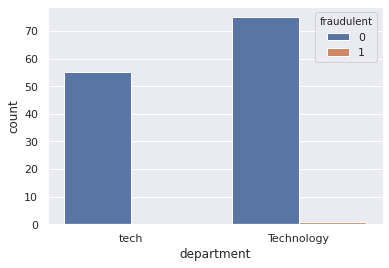

In [25]:
sns.countplot(x='department',data=df[((df['department']=='tech')|(df['department']=='Technology'))],hue='fraudulent');

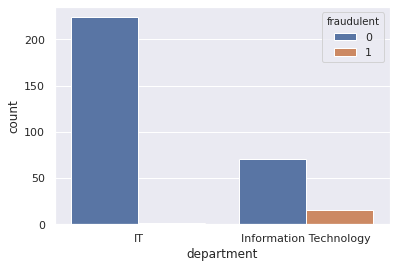

In [26]:
sns.countplot(x='department',data=df[((df['department']=='IT')|(df['department']=='Information Technology'))],hue='fraudulent');

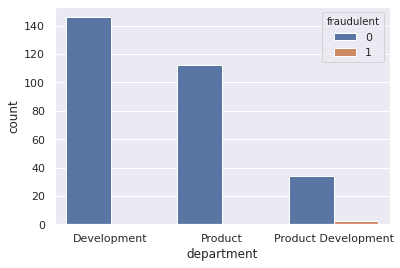

In [27]:
sns.countplot(x='department',data=df[((df['department']=='Development')|(df['department']=='Product')|(df['department']=='Product Development'))],hue='fraudulent');

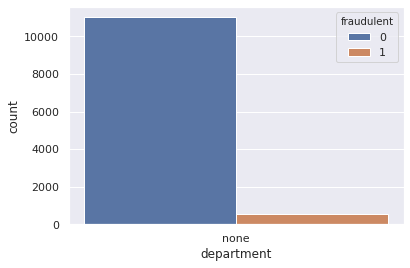

In [28]:
sns.countplot(x='department',data=df[df['department']=='none'],hue='fraudulent');

<p>There are a lot of jobs which have the same department but use different terms.Fraudulent ads seem to be biased towards a particular term for a department but this may also be due to fewer fraudulent ads.</p>
<p>Most of the authentic jobs also didn't specify the depatment.</p>

In [29]:
df['salary_range'].nunique()

874

In [30]:
df[df['salary_range'].notnull()]['salary_range']

6          20000-28000
10       100000-120000
15       120000-150000
23       100000-120000
31         50000-65000
             ...      
17844              0-0
17849     80000-100000
17865      18000-20000
17867      18000-19000
17874     80000-100000
Name: salary_range, Length: 2868, dtype: object

In [31]:
salary=df['salary_range'].apply(lambda x:str(x).strip().split('-'))
salary=salary.apply(pd.Series)

In [32]:
# Function to check fot non integer values
def int_check(x):
    try:
        int(x)
    except:
        if x!='nan':
            print(x)

In [33]:
salary[0].apply(int_check)

Oct
Oct
Jun
Oct
Dec


0        None
1        None
2        None
3        None
4        None
         ... 
17875    None
17876    None
17877    None
17878    None
17879    None
Name: 0, Length: 17880, dtype: object

In [34]:
def int_convert(x):
    try:
        return int(x)
    except:
        return 0

In [35]:
df['salary_lower_bound']=salary[0]
df['salary_lower_bound']=df['salary_lower_bound'].apply(int_convert)
df['salary_upper_bound']=salary[1]
df['salary_upper_bound']=df['salary_upper_bound'].apply(int_convert)

In [36]:
df['avg_salary']=(df['salary_upper_bound']+df['salary_lower_bound'])/2

In [37]:
px.histogram(data_frame=df[(df['avg_salary']<=100000)&(df['avg_salary']!=0)],x="avg_salary",color='fraudulent',marginal='rug')

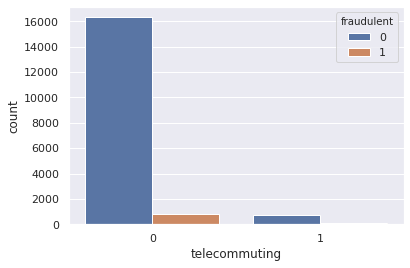

In [38]:
sns.countplot(x='telecommuting',data=df,hue='fraudulent');

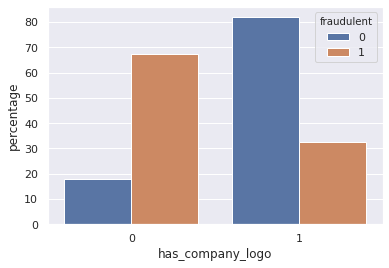

In [39]:
sns.barplot(x="has_company_logo", y="percentage", hue="fraudulent", data=df.groupby(['fraudulent'])['has_company_logo']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('has_company_logo'));

<p>As expected, most of the fraudulent job ads don't have a company logo.</p>

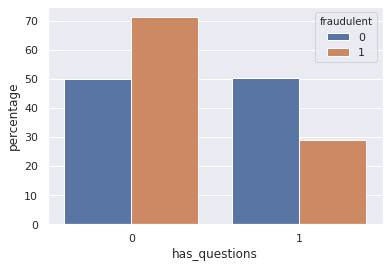

In [40]:
sns.barplot(x="has_questions", y="percentage", hue="fraudulent", data=df.groupby(['fraudulent'])['has_questions']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('has_questions'));

In [41]:
df['employment_type'].unique()

array(['Other', 'Full-time', nan, 'Part-time', 'Contract', 'Temporary'],
      dtype=object)

In [42]:
df['employment_type'].fillna("none",inplace=True)

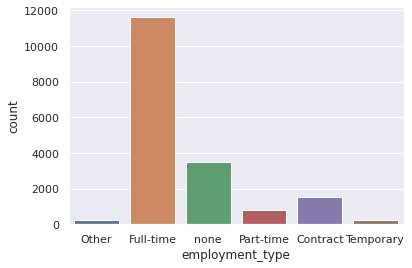

In [43]:
sns.countplot(x='employment_type',data=df);

In [44]:
df['required_experience'].unique()

array(['Internship', 'Not Applicable', nan, 'Mid-Senior level',
       'Associate', 'Entry level', 'Executive', 'Director'], dtype=object)

In [45]:
df[df['required_experience']=='Not Applicable'].head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,country,location_count,null_count,salary_lower_bound,salary_upper_bound,avg_salary
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,NaN,Marketing and Advertising,Customer Service,0,NZL,1,2,0,0,0.0
13,14,Installers,"US, FL, Orlando",none,NaN,Growing event production company providing sta...,"Event Industry Installers Needed!! (Orlando, F...","Valid driver's license,Somewhat Clean driving ...",NaN,0,...,Unspecified,Events Services,Other,0,USA,1,3,0,0,0.0
59,60,Product Visual Designer,"US, CA, San Francisco",none,NaN,"From the lands of Can Do, Roll Our Sleeves Up ...",Apcera is revolutionizing enterprise technolog...,RESPONSIBILITIES:Work with the UX architect's ...,Competitive salary &amp; equityGreat location ...,0,...,Unspecified,Information Technology and Services,Design,0,USA,1,2,0,0,0.0
94,95,WF17 9LU Customer Service Apprenticeship under...,"GB, , Birstall",none,NaN,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,...,High School or equivalent,NaN,Administrative,0,GBR,1,3,0,0,0.0
107,108,Senior Developer at a Startup Investment Studio,"GB, LND, London",FP,50000-70000,"Based in Hoxton, London, Forward Partners are ...",Forward Partners invest in very early stage e-...,About youYou should be expert in one language ...,NaN,0,...,Unspecified,Venture Capital & Private Equity,Information Technology,0,GBR,1,1,50000,70000,60000.0


In [46]:
df[df['required_experience'].isnull()].head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,country,location_count,null_count,salary_lower_bound,salary_upper_bound,avg_salary
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",none,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,NaN,NaN,NaN,0,USA,1,8,0,0,0.0
5,6,Accounting Clerk,"US, MD,",none,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,...,NaN,NaN,NaN,0,USA,1,10,0,0,0.0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",none,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,...,NaN,NaN,NaN,0,USA,1,7,0,0,0.0
11,12,Talent Sourcer (6 months fixed-term contract),"GB, LND, London",HR,NaN,Want to build a 21st century financial service...,TransferWise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,...,NaN,NaN,NaN,0,GBR,1,6,0,0,0.0
17,18,Southend-on-Sea Traineeships Under NAS 16-18 Y...,"GB, SOS, Southend-on-Sea",none,NaN,Established on the principles that full time e...,Government funding is only available for 16-18...,16-18 year olds only due to government funding...,Career prospects.,0,...,NaN,NaN,NaN,0,GBR,1,7,0,0,0.0


<p>Missing required_experience value may indicate 'Not Applicable'</p>

In [47]:
df['required_experience'].fillna('Not Applicable',inplace=True)

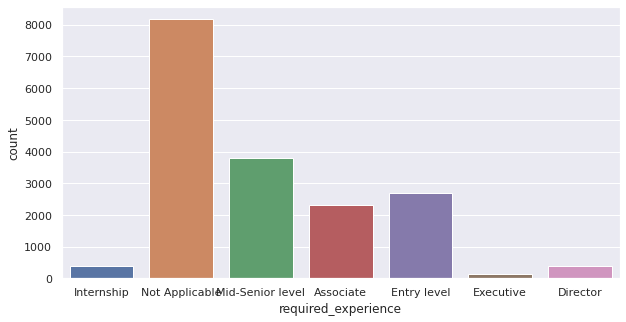

In [48]:
plt.figure(figsize=(10,5))
sns.countplot(x='required_experience',data=df);

In [49]:
df['required_education'].unique()

array([nan, "Bachelor's Degree", "Master's Degree",
       'High School or equivalent', 'Unspecified',
       'Some College Coursework Completed', 'Vocational', 'Certification',
       'Associate Degree', 'Professional', 'Doctorate',
       'Some High School Coursework', 'Vocational - Degree',
       'Vocational - HS Diploma'], dtype=object)

In [50]:
df['required_education'].fillna('Unspecified',inplace=True)

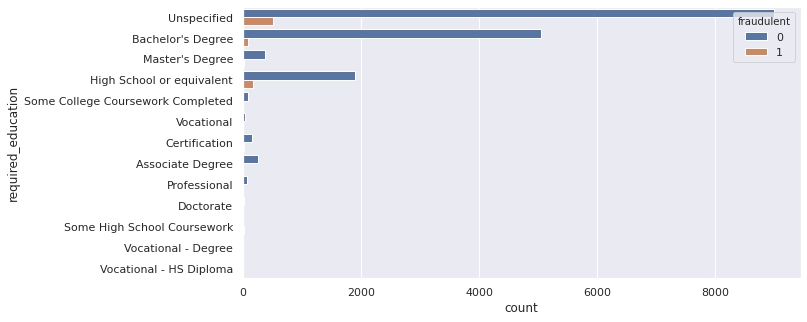

In [51]:
plt.figure(figsize=(10,5))
sns.countplot(y='required_education',data=df,hue='fraudulent');

In [52]:
df['industry'].unique()

array([nan, 'Marketing and Advertising', 'Computer Software',
       'Hospital & Health Care', 'Online Media',
       'Information Technology and Services', 'Financial Services',
       'Management Consulting', 'Events Services', 'Internet',
       'Facilities Services', 'Consumer Electronics',
       'Telecommunications', 'Consumer Services', 'Construction',
       'Oil & Energy', 'Education Management', 'Building Materials',
       'Banking', 'Food & Beverages', 'Food Production',
       'Health, Wellness and Fitness', 'Insurance', 'E-Learning',
       'Cosmetics', 'Staffing and Recruiting',
       'Venture Capital & Private Equity', 'Leisure, Travel & Tourism',
       'Human Resources', 'Pharmaceuticals', 'Farming', 'Legal Services',
       'Luxury Goods & Jewelry', 'Machinery', 'Real Estate',
       'Mechanical or Industrial Engineering',
       'Public Relations and Communications', 'Consumer Goods',
       'Medical Practice', 'Electrical/Electronic Manufacturing',
       'Hospita

In [53]:
df['industry'].fillna('not specified',inplace=True)

In [54]:
df['function'].unique()

array(['Marketing', 'Customer Service', nan, 'Sales',
       'Health Care Provider', 'Management', 'Information Technology',
       'Other', 'Engineering', 'Administrative', 'Design', 'Production',
       'Education', 'Supply Chain', 'Business Development',
       'Product Management', 'Financial Analyst', 'Consulting',
       'Human Resources', 'Project Management', 'Manufacturing',
       'Public Relations', 'Strategy/Planning', 'Advertising', 'Finance',
       'General Business', 'Research', 'Accounting/Auditing',
       'Art/Creative', 'Quality Assurance', 'Data Analyst',
       'Business Analyst', 'Writing/Editing', 'Distribution', 'Science',
       'Training', 'Purchasing', 'Legal'], dtype=object)

In [55]:
df['function'].fillna('not specified',inplace=True)

In [56]:
df[(df['company_profile'].isnull())&(df['fraudulent']==0)]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,country,location_count,null_count,salary_lower_bound,salary_upper_bound,avg_salary
5,6,Accounting Clerk,"US, MD,",none,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,...,Unspecified,not specified,not specified,0,USA,1,10,0,0,0.0
10,11,ASP.net Developer Job opportunity at United St...,"US, NJ, Jersey City",none,100000-120000,NaN,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - FullBonus Eligible - YesInterview T...,0,...,Bachelor's Degree,Information Technology and Services,Information Technology,0,USA,1,2,100000,120000,110000.0
24,25,Customer Service,"GB, LND, London",none,NaN,NaN,We are a canary wharf based e-commerce company...,NaN,NaN,0,...,Unspecified,not specified,not specified,0,GBR,1,10,0,0,0.0
31,32,Software Applications Specialist,"US, KS,",none,50000-65000,NaN,"Day to Day-Install, upgrade and configure web-...",Must Have's3+ years of experience with web-bas...,"Medical, Dental, Vision, Life, Disability, Pre...",0,...,Unspecified,Computer Software,Engineering,0,USA,1,2,50000,65000,57500.0
37,38,PROJECT MANAGER,"US, TX, HOUSTON",none,NaN,NaN,we are looking for a Project Manager. The Proj...,NaN,NaN,0,...,Bachelor's Degree,Oil & Energy,Engineering,0,USA,1,5,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867,17868,Admin Assistant,"GB, WSX, Chichester",Sales,18000-19000,NaN,We are seeking an administrator to work in a b...,Proficient experience in Microsoft Word and Ex...,"Salary £18,000Commission available after quali...",0,...,Unspecified,Human Resources,Sales,0,GBR,1,1,18000,19000,18500.0
17869,17870,Sr Technical Lead LIMS,"US, DE, Wilmington",none,NaN,NaN,Job Title: Sr Technical LeadSalary: OpenDurat...,Responsibilities: He should be extensive knowl...,NaN,0,...,Unspecified,Pharmaceuticals,not specified,0,USA,1,7,0,0,0.0
17873,17874,Recruiting Coordinator,"US, NC, Charlotte",none,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,0,...,Unspecified,Utilities,not specified,0,USA,1,7,0,0,0.0
17874,17875,JavaScript Developer,"US, ,",none,80000-100000,NaN,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,NaN,0,...,Bachelor's Degree,Computer Software,Information Technology,0,USA,1,4,80000,100000,90000.0


<p>A lot of genuine job ads haven't specified company profile</p>

In [57]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
}

stop_words=stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def text_preprocess(x):
    if pd.isnull(x) or x=='nan':
        return "not specified"
    x=str(x)
    x=x.lower()
    #remove url,email,phone number and links
    x=re.sub("(#url_.*#)|(#email.*#)|(#phone.*#)|((http|https)://\w*)",' ',x)
    # remove abbreviations
    pattern = re.compile(r'\b(' + '|'.join(abbr_dict.keys()) + r')\b')
    x = pattern.sub(lambda x: abbr_dict[x.group()], x)
    tokens = re.findall("[\w']+", x)
    tokens=[word for word in tokens if ((word not in stop_words) and (len(word)>1) and not(word.isdigit()))]
    lemmatized_tokens=list(map(lemmatizer.lemmatize,tokens))
    string=""
    for word in lemmatized_tokens:
        string+=word+' '
    return string
    

In [58]:
df['text']=df[['title', 'company_profile', 'description','requirements','benefits']].fillna('').agg(' '.join, axis=1)

In [59]:
df['text_length']=df['text'].apply(lambda x:len(x.split()))

In [60]:
px.histogram(data_frame=df,x="text_length",color='fraudulent',marginal='rug')

In [61]:
df['text']=df['text'].apply(text_preprocess)

In [62]:
df['company_profile'].apply(lambda x:print(x) if 'see more' in str(x).lower() else False)

At LendInvest fundamentally changing the way people think about their savings, investments and how you get a mortgage. We're the new generation of finance, which is far less stuffy as we are building a new way to do things - and having some fun along the way. If you want to be part of building the future of finance, then we'd love to hear from you. LendInvest has been prominently recognised as a leader for its growth and innovation. We are based in a prime central London building, with a very cool work environment.LendInvest is a direct employer and we therefore do not work with any recruitment agencies. Recruiters, please do not spam us, we are not interested in hearing from you.For a look at what we're creating, you can see more on our site at: #URL_a472ef05be663cdc9df7eb234d26330394196f039430435745cd6695790fd82e#
The Amani Institute is about developing whole individuals who have the knowledge and practical skills required to solve today's problems and the networks to be equipped to 

0        False
1        False
2        False
3        False
4        False
         ...  
17875    False
17876    False
17877    False
17878    False
17879    False
Name: company_profile, Length: 17880, dtype: object

In [63]:
df[df['company_profile'].apply(lambda x:True if 'see more' in str(x).lower() else False)]['company_profile'].count()

46

<p>'See more at #url' may be link to company's website</p>
<p>Most of the companies posting job ad on this platform don't have a website</p> 

In [64]:
x_train,x_test,y_train,y_test=train_test_split(df, df['fraudulent'], test_size=0.2,stratify=df['fraudulent'], random_state=42)

In [65]:
numerical_features=['telecommuting','has_company_logo','has_questions','location_count','null_count','text_length']

scaler=StandardScaler()
num_train=csr_matrix(scaler.fit_transform(x_train[numerical_features]))
num_test=csr_matrix(scaler.transform(x_test[numerical_features]))

In [66]:
ohe=OneHotEncoder()
ohe_train=ohe.fit_transform(x_train[['required_education','employment_type','required_experience']])
ohe_test=ohe.transform(x_test[['required_education','employment_type','required_experience']])

In [67]:
bow=CountVectorizer(ngram_range=(1,2))
text_train=bow.fit_transform(x_train['text'])
text_test=bow.transform(x_test['text'])

In [68]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [69]:
params={'C':[1,10,100,1000]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

1.0
0.8768768768768769
[[13611     0]
 [    0   693]]
[[3389   14]
 [  27  146]]


In [70]:
tfidf=TfidfVectorizer(ngram_range=(1,2))
text_train=tfidf.fit_transform(x_train['text'])
text_test=tfidf.transform(x_test['text'])

In [71]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [72]:
params={'C':[1,10,100,1000]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

1.0
0.9272727272727272
[[13611     0]
 [    0   693]]
[[3399    4]
 [  20  153]]


In [73]:
embeddings_index = {}
f = open('/kaggle/input/glove6b/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [01:02, 6407.93it/s]

Found 400000 word vectors.


In [74]:
# Function to generate TF-IDF weighted glove embedding
def glove_embedding(x):
    embed=[]
    tfidf_dict=tfidf.vocabulary_
    x=list(x.split())
    for word in x:
        try:
            embed.append(embeddings_index[word]*tfidf_dict[word])
        except:
            continue
    return np.mean(embed,axis=0)

In [75]:
text_train=x_train['text'].apply(glove_embedding)
text_test=x_test['text'].apply(glove_embedding)
text_train=text_train.apply(pd.Series)
text_test=text_test.apply(pd.Series)

In [76]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [77]:
params={'C':[0.01,0.1,1,10]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.42323369565217395
0.3567708333333333
[[11983  1628]
 [   70   623]]
[[2945  458]
 [  36  137]]


In [78]:
clf=RandomForestClassifier(n_estimators=500,oob_score=True,n_jobs=-1,random_state=0)
clf.fit(text_train,y_train)
print(f1_score(y_train,clf.predict(text_train)))
print(f1_score(y_test,clf.predict(text_test)))
print(confusion_matrix(y_train,clf.predict(text_train)))
print(confusion_matrix(y_test,clf.predict(text_test)))

1.0
0.5761316872427983
[[13611     0]
 [    0   693]]
[[3403    0]
 [ 103   70]]


In [79]:
train_data = lgb.Dataset(combined_train, label=y_train)
test_data = lgb.Dataset(combined_test, label=y_test)

In [80]:
params = {}
params['learning_rate'] = 0.04
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['max_depth'] = 5
params['lambda_l1'] = 0
params['lambda_l2'] = 0
params['n_jobs'] = 4
params['class_weight']='balanced'

clf = lgb.train( params,train_data, 1000, valid_sets=[test_data])

[1]	valid_0's binary_logloss: 0.181721
[2]	valid_0's binary_logloss: 0.172967
[3]	valid_0's binary_logloss: 0.167454
[4]	valid_0's binary_logloss: 0.162378
[5]	valid_0's binary_logloss: 0.15741
[6]	valid_0's binary_logloss: 0.153664
[7]	valid_0's binary_logloss: 0.149788
[8]	valid_0's binary_logloss: 0.146692
[9]	valid_0's binary_logloss: 0.144339
[10]	valid_0's binary_logloss: 0.141506
[11]	valid_0's binary_logloss: 0.13909
[12]	valid_0's binary_logloss: 0.136617
[13]	valid_0's binary_logloss: 0.13413
[14]	valid_0's binary_logloss: 0.131763
[15]	valid_0's binary_logloss: 0.129858
[16]	valid_0's binary_logloss: 0.127926
[17]	valid_0's binary_logloss: 0.126205
[18]	valid_0's binary_logloss: 0.124718
[19]	valid_0's binary_logloss: 0.122992
[20]	valid_0's binary_logloss: 0.121341
[21]	valid_0's binary_logloss: 0.119888
[22]	valid_0's binary_logloss: 0.118392
[23]	valid_0's binary_logloss: 0.116855
[24]	valid_0's binary_logloss: 0.115463
[25]	valid_0's binary_logloss: 0.114259
[26]	valid_0

[204]	valid_0's binary_logloss: 0.0675189
[205]	valid_0's binary_logloss: 0.0675751
[206]	valid_0's binary_logloss: 0.0674736
[207]	valid_0's binary_logloss: 0.0674286
[208]	valid_0's binary_logloss: 0.0674061
[209]	valid_0's binary_logloss: 0.0672943
[210]	valid_0's binary_logloss: 0.0672677
[211]	valid_0's binary_logloss: 0.0672366
[212]	valid_0's binary_logloss: 0.0672835
[213]	valid_0's binary_logloss: 0.0672841
[214]	valid_0's binary_logloss: 0.0672408
[215]	valid_0's binary_logloss: 0.0672009
[216]	valid_0's binary_logloss: 0.0671472
[217]	valid_0's binary_logloss: 0.067197
[218]	valid_0's binary_logloss: 0.0671413
[219]	valid_0's binary_logloss: 0.0671548
[220]	valid_0's binary_logloss: 0.0669886
[221]	valid_0's binary_logloss: 0.0669017
[222]	valid_0's binary_logloss: 0.0667912
[223]	valid_0's binary_logloss: 0.0667051
[224]	valid_0's binary_logloss: 0.0666679
[225]	valid_0's binary_logloss: 0.0666171
[226]	valid_0's binary_logloss: 0.0664896
[227]	valid_0's binary_logloss: 0.0

[406]	valid_0's binary_logloss: 0.0696004
[407]	valid_0's binary_logloss: 0.0695967
[408]	valid_0's binary_logloss: 0.0697191
[409]	valid_0's binary_logloss: 0.0697578
[410]	valid_0's binary_logloss: 0.0698582
[411]	valid_0's binary_logloss: 0.0699332
[412]	valid_0's binary_logloss: 0.0699545
[413]	valid_0's binary_logloss: 0.0699999
[414]	valid_0's binary_logloss: 0.0700424
[415]	valid_0's binary_logloss: 0.0701056
[416]	valid_0's binary_logloss: 0.0702178
[417]	valid_0's binary_logloss: 0.0702883
[418]	valid_0's binary_logloss: 0.0703353
[419]	valid_0's binary_logloss: 0.0703164
[420]	valid_0's binary_logloss: 0.0703654
[421]	valid_0's binary_logloss: 0.0704818
[422]	valid_0's binary_logloss: 0.0705287
[423]	valid_0's binary_logloss: 0.0706076
[424]	valid_0's binary_logloss: 0.0706729
[425]	valid_0's binary_logloss: 0.0707752
[426]	valid_0's binary_logloss: 0.0706357
[427]	valid_0's binary_logloss: 0.0706797
[428]	valid_0's binary_logloss: 0.070745
[429]	valid_0's binary_logloss: 0.0

[604]	valid_0's binary_logloss: 0.0801724
[605]	valid_0's binary_logloss: 0.0802203
[606]	valid_0's binary_logloss: 0.0802483
[607]	valid_0's binary_logloss: 0.0803125
[608]	valid_0's binary_logloss: 0.0803592
[609]	valid_0's binary_logloss: 0.0804568
[610]	valid_0's binary_logloss: 0.0805811
[611]	valid_0's binary_logloss: 0.080623
[612]	valid_0's binary_logloss: 0.0807134
[613]	valid_0's binary_logloss: 0.0807224
[614]	valid_0's binary_logloss: 0.0807775
[615]	valid_0's binary_logloss: 0.0808409
[616]	valid_0's binary_logloss: 0.0809001
[617]	valid_0's binary_logloss: 0.0809274
[618]	valid_0's binary_logloss: 0.0809529
[619]	valid_0's binary_logloss: 0.0809897
[620]	valid_0's binary_logloss: 0.0809666
[621]	valid_0's binary_logloss: 0.0810967
[622]	valid_0's binary_logloss: 0.0811773
[623]	valid_0's binary_logloss: 0.0812929
[624]	valid_0's binary_logloss: 0.0813744
[625]	valid_0's binary_logloss: 0.0814805
[626]	valid_0's binary_logloss: 0.0815447
[627]	valid_0's binary_logloss: 0.0

[806]	valid_0's binary_logloss: 0.0935395
[807]	valid_0's binary_logloss: 0.0936245
[808]	valid_0's binary_logloss: 0.0935126
[809]	valid_0's binary_logloss: 0.0935088
[810]	valid_0's binary_logloss: 0.0935909
[811]	valid_0's binary_logloss: 0.0936422
[812]	valid_0's binary_logloss: 0.0937014
[813]	valid_0's binary_logloss: 0.0938169
[814]	valid_0's binary_logloss: 0.0939142
[815]	valid_0's binary_logloss: 0.0939716
[816]	valid_0's binary_logloss: 0.0939684
[817]	valid_0's binary_logloss: 0.0939383
[818]	valid_0's binary_logloss: 0.093934
[819]	valid_0's binary_logloss: 0.0939619
[820]	valid_0's binary_logloss: 0.0940652
[821]	valid_0's binary_logloss: 0.0940693
[822]	valid_0's binary_logloss: 0.0941854
[823]	valid_0's binary_logloss: 0.0942757
[824]	valid_0's binary_logloss: 0.0943401
[825]	valid_0's binary_logloss: 0.0944253
[826]	valid_0's binary_logloss: 0.0944319
[827]	valid_0's binary_logloss: 0.0944274
[828]	valid_0's binary_logloss: 0.0944599
[829]	valid_0's binary_logloss: 0.0

In [81]:
thresh=0.20
print(f1_score(y_train,list(map(lambda x:1 if x>thresh else 0,clf.predict(combined_train)))))
print(f1_score(y_test,list(map(lambda x:1 if x>thresh else 0,clf.predict(combined_test)))))
print(confusion_matrix(y_train,list(map(lambda x:1 if x>thresh else 0,clf.predict(combined_train)))))
print(confusion_matrix(y_test,list(map(lambda x:1 if x>thresh else 0,clf.predict(combined_test)))))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:546: UserWarning:

Converting data to scipy sparse matrix.



1.0
0.7789473684210525
[[13611     0]
 [    0   693]]
[[3402    1]
 [  62  111]]


In [82]:
# bert_df=df.iloc[:,[23,17]]
# bert_df.columns=['text','labels']
# bert_df['text']=bert_df['text'].apply(text_preprocess)
# train_df,eval_df=train_test_split(bert_df, test_size=0.2,stratify=bert_df['labels'], random_state=42)

In [83]:
#!pip install spacy==2.1.9

In [84]:
#!pip install simpletransformers wandb 

In [85]:
# from simpletransformers.classification import ClassificationModel

# args={"learning_rate": 3e-5,"save_steps": 4000,"manual_seed": 0,'save_model_every_epoch':False,'sliding_window': True,
#         'fp16': False, 
#         'train_batch_size': 64, 
#         'do_lower_case': True,
#         'overwrite_output_dir': True, 
#         'num_train_epochs':2
#      }

# model = ClassificationModel('roberta', 'roberta-base', num_labels=2,use_cuda=True,args=args)
# model.train_model(train_df)

In [86]:
# result, model_outputs, wrong_predictions = model.eval_model(train_df,acc=f1_score)
# print('[',result['tn'],',',result['fp'],']','\n[',result['fn'],',',result['tp'],']')
# print("f1_score: ",result['acc'])